In [1]:
import matplotlib.pyplot as plt
from reproject import reproject_interp

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

import sunpy.map
from sunpy.coordinates import Helioprojective, RotatedSunFrame, transform_with_sun_center
from sunpy.net import Fido, attrs as a

import datetime

import aiapy
from aiapy.calibrate import register, update_pointing, normalize_exposure

import warnings
warnings.filterwarnings("ignore")

print(sunpy.__version__)
print(aiapy.__version__)


3.0.1
0.6.0


Results from 2 Providers:

1 Results from the VSOClient:
       Start Time       ...
                        ...
----------------------- ...
2021-01-01 00:06:05.000 ...

1 Results from the VSOClient:
       Start Time               End Time        ...             Info            
                                                ...                             
----------------------- ----------------------- ... ----------------------------
2021-01-01 00:06:15.000 2021-01-01 00:06:19.000 ... EUVI ;  ; NORMAL ; 2048x2048




Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

20210101_000615_n4eua.fts:   0%|          | 0.00/8.41M [00:00<?, ?B/s]

aia_lev1_304a_2021_01_01t00_06_05_13z_image_lev1.fits:   0%|          | 0.00/7.28M [00:00<?, ?B/s]

['/Users/rbmasek/sunpy/data/20210101_000615_n4eua.fts', '/Users/rbmasek/sunpy/data/aia_lev1_304a_2021_01_01t00_06_05_13z_image_lev1.fits']


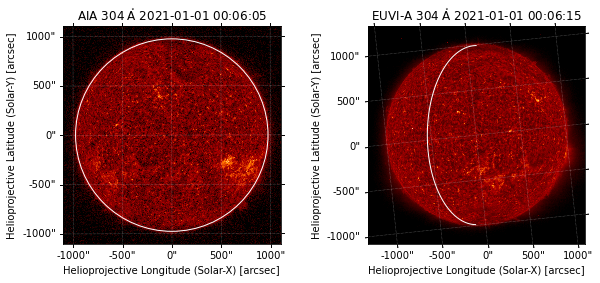

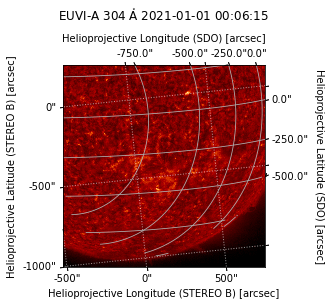

In [2]:
"""
===========================================
Drawing the AIA limb on a STEREO EUVI image
===========================================

In this example we use a STEREO-B and an SDO image to demonstrate how to
overplot the limb as seen by AIA on an EUVI-B image. Then we overplot the AIA
coordinate grid on the STEREO image.
"""
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.coordinates.wcs_utils
import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a

###############################################################################
# The first step is to download some data. We download an image from STEREO-A
# and an image from SDO, which are separated in longitude.

stereo = (a.Source('STEREO_A') &
          a.Instrument("EUVI") &
          a.Time('2021-01-01 00:06', '2021-01-01 00:07'))

aia = (a.Instrument.aia &
       a.Sample(24 * u.hour) &
       a.Time('2021-01-01 00:06', '2021-01-02 00:06'))

wave = a.Wavelength(30 * u.nm, 31 * u.nm)
result = Fido.search(wave, aia | stereo)

###############################################################################
# Let's inspect the result and download the files.

print(result)
downloaded_files = Fido.fetch(result)
print(downloaded_files)

##############################################################################
# Let's create a dictionary with the two maps, which we crop to full disk.

maps = {m.detector: m.submap(SkyCoord([-1100, 1100], [-1100, 1100],
                                      unit=u.arcsec, frame=m.coordinate_frame))
        for m in sunpy.map.Map(downloaded_files)}
maps['AIA'].plot_settings['vmin'] = 0  # set the minimum plotted pixel value

##############################################################################
# Now, let's plot both maps, and we draw the limb as seen by AIA onto the
# EUVI image. We remove the part of the limb that is hidden because it is on
# the far side of the Sun from STEREO's point of view.

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1, projection=maps['AIA'])
maps['AIA'].plot(axes=ax1)
maps['AIA'].draw_limb()

ax2 = fig.add_subplot(1, 2, 2, projection=maps['EUVI'])
maps['EUVI'].plot(axes=ax2)
visible, hidden = maps['AIA'].draw_limb()
hidden.remove()

##############################################################################
# Let's plot the helioprojective coordinate grid as seen by SDO on the STEREO
# image in a cropped view.  Note that only those grid lines that intersect the
# edge of the plot will have corresponding ticks and tick labels.

fig = plt.figure()
ax = plt.subplot(projection=maps['EUVI'])

maps['EUVI'].plot()

# Crop the view using pixel coordinates
ax.set_xlim(500, 1300)
ax.set_ylim(100, 900)

# Shrink the plot slightly and move the title up to make room for new labels.
ax.set_position([0.1, 0.1, 0.8, 0.7])
ax.set_title(ax.get_title(), pad=45)

# Change the default grid labels and line properties.
stereo_x, stereo_y = ax.coords
stereo_x.set_axislabel("Helioprojective Longitude (STEREO B) [arcsec]")
stereo_y.set_axislabel("Helioprojective Latitude (STEREO B) [arcsec]")
ax.coords.grid(color='white', linewidth=1)

# Add a new coordinate overlay in the SDO frame.
overlay = ax.get_coords_overlay(maps['AIA'].coordinate_frame)
overlay.grid()

# Configure the grid:
x, y = overlay

# Wrap the longitude at 180 deg rather than the default 360.
x.set_coord_type('longitude', 180.)

# Set the tick spacing
x.set_ticks(spacing=250*u.arcsec)
y.set_ticks(spacing=250*u.arcsec)

# Set the ticks to be on the top and left axes.
x.set_ticks_position('tr')
y.set_ticks_position('tr')

# Change the defaults to arcseconds
x.set_major_formatter('s.s')
y.set_major_formatter('s.s')

# Add axes labels
x.set_axislabel("Helioprojective Longitude (SDO) [arcsec]")
y.set_axislabel("Helioprojective Latitude (SDO) [arcsec]")

plt.show()

In [2]:
current_date = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

past = datetime.datetime.now()-datetime.timedelta(minutes=2)

past_date = past.strftime("%Y-%m-%dT%H:%M:%S")

print(past_date)
print(current_date)

startt = str(past_date)
endt= str(current_date)

result = Fido.search(a.Time(startt, endt),
                     a.Instrument("aia"), a.Wavelength(94*u.angstrom) )
print(result)

2021-11-02T16:05:56
2021-11-02T16:07:56
Results from 1 Provider:

1 Results from the VSOClient:
       Start Time               End Time        ...             Info            
                                                ...                             
----------------------- ----------------------- ... ----------------------------
2021-11-02 16:06:00.000 2021-11-02 16:06:00.000 ... AIA level 1.5 NRT, 1024x1024




Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia20211102_160600_0094.fits:   0%|          | 0.00/4.21M [00:00<?, ?B/s]

2021-11-02T16:05:59.116


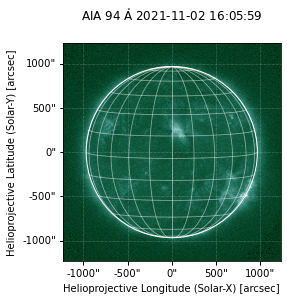

In [3]:
file_download = Fido.fetch(result[0, 0], site='ROB')
aiamap = sunpy.map.Map(file_download[0])
print(aiamap.date)

fig = plt.figure()
ax = fig.add_subplot(111, projection=aiamap)
aiamap.plot()
aiamap.draw_limb()
aiamap.draw_grid()

plt.show()

In [4]:
def draw_nustar_fov(in_map, center_x, center_y, layers=[-100, 0, 100], colors='red'):
    """
    Draw squares representing NuSTAR's field of view on the current map.
    
    By default, three squares are drawn: one that is equal
    to the 12x12 arcminute FOV and two with side lengths
    of +-100 arcseconds from the actual side lengths.
    
    Parameters
    ----------
    in_map : Sunpy map
        The input map on which the squares will be overlaid.
    center_x : float
        The x position, in arcseconds, of the squares' center point.
    center_y : float
        The y position, in arcseconds, of the squares' center point.
    layers : list
        List of values, in arcseconds, containing the adjustments
        to the side lengths of the drawn squares. Each value results
        in a new square drawn on the map.
    colors : str or list of str
        The colors of the drawn squares. If colors is a string,
        then each square will be drawn with that color.
        Otherwise, a list can be provided to customize the color
        of each layer. The index of the color will match the index
        of the layer.
    """
    
    # Change the colors variable to a list if it's not already one.
    if not isinstance(colors, list):
        colors = [colors]*len(layers)
    
    FOV_SIDE_LENGTH = 12*60 # Units of arcseconds

    for i, diff in enumerate(layers):
        # Translate to bottom left corner of rectangle
        bottom_left = ((center_x - FOV_SIDE_LENGTH/2 - diff)*u.arcsec,
                       (center_y - FOV_SIDE_LENGTH/2 - diff)*u.arcsec)
        rect_bl = SkyCoord(*bottom_left, frame=in_map.coordinate_frame)

        in_map.draw_quadrangle(bottom_left=rect_bl,
                                 width=(FOV_SIDE_LENGTH+2*diff)*u.arcsec,
                                 height=(FOV_SIDE_LENGTH+2*diff)*u.arcsec,
                                 color=colors[i])

<RotatedSunHelioprojective Frame (base=<Helioprojective Frame (obstime=2021-11-21T12:00:00.000, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>)>, duration=-18.829176898148148 d, rotation_model=howard)>


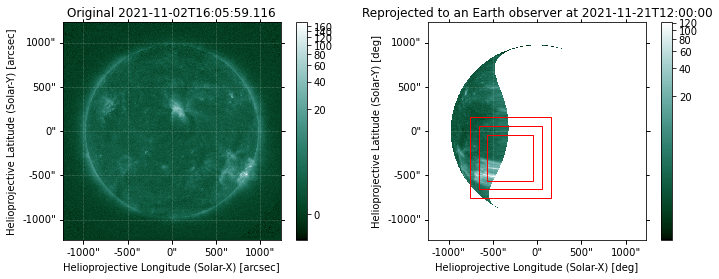

In [5]:
in_time = aiamap.date
out_time = '2021-11-21T12:00:00'
out_frame = Helioprojective(observer='earth', obstime=out_time, rsun=aiamap.coordinate_frame.rsun)
rot_frame = RotatedSunFrame(base=out_frame, rotated_time=in_time)
print(rot_frame)

out_shape = aiamap.data.shape
out_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=out_frame)
header = sunpy.map.make_fitswcs_header(out_shape,
                                       out_center,
                                       scale=u.Quantity(aiamap.scale))
out_wcs = WCS(header)
out_wcs.coordinate_frame = rot_frame

with transform_with_sun_center():
    arr, _ = reproject_interp(aiamap, out_wcs, out_shape)
    
out_warp = sunpy.map.Map(arr, out_wcs)
out_warp.plot_settings = aiamap.plot_settings

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1, projection=aiamap)
aiamap.plot(title=f'Original {in_time}')
plt.colorbar()

ax2 = fig.add_subplot(1, 2, 2, projection=out_warp)
out_warp.plot(title=f"Reprojected to an Earth observer at {out_time}")
plt.colorbar()

# Set coordinates for NuSTAR FOV.
center_x = -300
center_y = -300
layers = [100, 0, -100]

draw_nustar_fov(out_warp, center_x, center_y, layers)

plt.show()